## Convolutional Neural Networks to classify Quark-Gluon events

In this notebook, we implement a CNN to Quark-Gluon dataset. First, we preprocess the dataset using the following path: 
- load the test file with consist of 4 files: "X_jets", "m0", "pt" and "y".
- Load only the "X_jets" file which consists of almost 140 000 images of 125x125 pixels and 3 channels.
- Channels correspond to different information about the event: tracker, ECAL, and HCAL.
- Here we only use the ECAL channel to classify events.
- 



In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
test = h5py.File("/home/lazaror/quantum/pruebas/Takhur_QCNN/Equivariant_QCNN/data/hep_data/quark-gluon_test-set_n139306.hdf5","r")
x_s = test.get('X_jets')
y_s = test.get('y')

x_s.shape

(139306, 125, 125, 3)

In [6]:
test.keys()

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>

In [92]:
n=11
print(f"2**{n}= {2**n}, closest root = {int(np.sqrt(2**n))}")

2**11= 2048, closest root = 45


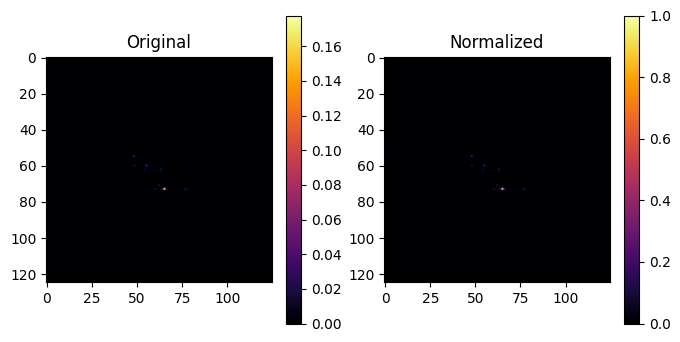

In [9]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x_s[0,:,:,1], cmap = "inferno")
plt.colorbar()


X = x_s[0,:,:,1]
X = X/X.max()


plt.subplot(1,2,2)
plt.title("Normalized")
plt.imshow(X, cmap = "inferno")
plt.colorbar()

MinMaxScaler()
0.0


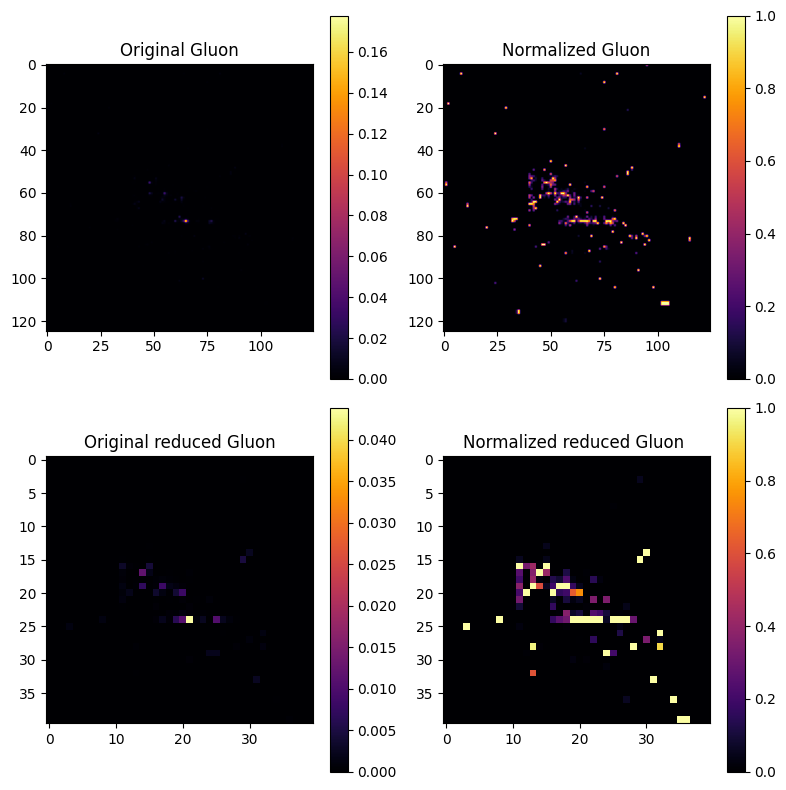

In [41]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


sample = 0

data = x_s[sample,:,:,1]
scale = 40
cropped = tf.image.central_crop(data.reshape(125, 125,1), 0.8)
reduced_sample = tf.image.resize(cropped, (scale, scale), method="bilinear").numpy()


scaler = MinMaxScaler()
print(scaler.fit(reduced_sample.reshape(scale,scale)))

scaled_data = scaler.transform(reduced_sample.reshape(scale,scale))


scaler.fit(data.reshape(125,125))
original_norm_data = scaler.transform(data)

plt.figure(figsize=(8, 8))

print(y_s[sample])
plt.subplot(2, 2, 1)
plt.imshow(data, cmap = "inferno")
plt.title("Original Gluon")
plt.colorbar()


plt.subplot(2, 2, 2)
plt.imshow(original_norm_data, cmap = "inferno")
plt.title("Normalized Gluon")
plt.colorbar()


plt.subplot(2, 2, 3)
plt.title("Original reduced Gluon")
plt.imshow(reduced_sample, cmap = "inferno")
plt.colorbar()



plt.subplot(2, 2, 4)
plt.title("Normalized reduced Gluon ")
plt.imshow(scaled_data, cmap = "inferno")
plt.colorbar()

 

plt.tight_layout()  
plt.show()


In [50]:
# preprocess images in ECAL channel only 
n_samples = 15000
scale = 40
x_red = []


for sample in range(n_samples):
    data = x_s[sample,:,:,1]
    cropped = tf.image.central_crop(data.reshape(125, 125,1), 0.7)
    reduced_sample = tf.image.resize(cropped, (scale, scale), method="bilinear").numpy()
    scaler = MinMaxScaler()
    scaler.fit(reduced_sample.reshape(scale,scale))
    scaled_data = scaler.transform(reduced_sample.reshape(scale,scale))
    x_red.append(scaled_data)


y_red = y_s[:n_samples]

x_red = np.array(x_red)
y_red = np.array(y_red)


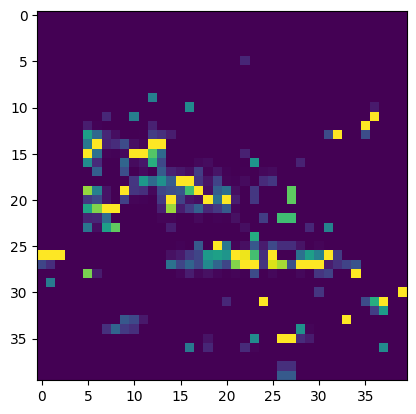

In [9]:
plt.imshow(x_red[0])

In [51]:
# Guardando los datos en un archivo h5py
with h5py.File('/home/lazaror/quantum/pruebas/Takhur_QCNN/Equivariant_QCNN/data/hep_data/quark-gluon-40x40-MMS-ECAL.h5', 'w') as f:
    f.create_dataset('x_red', data=x_red)
    f.create_dataset('y_red', data=y_red)

print("quark_gluon_data.h5 saved")

quark_gluon_data.h5 saved


In [42]:
#from sklearn.model_selection import train_test_split

#test = h5py.File("/home/lazaror/quantum/pruebas/Takhur_QCNN/Equivariant_QCNN/data/hep_data/quark-gluon-16x16-MMS.h5","r")
#x_s = test.get('x_red')
#y_s = test.get('y_red')

#X_train, X_test, Y_train, Y_test = train_test_split( np.array(x_s), np.array(y_s), test_size=0.25)

#X_train.shape


(7500, 16, 16)

## Classical CNN

In [11]:
y_red = (y_red+1)/2
y_red

array([0., 0., 1., ..., 0., 1., 1.], dtype=float32)

In [60]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split( np.array(x_red), np.array(y_red), test_size=0.25)


# Definir la arquitectura del modelo
model = Sequential([
    Conv2D(1, (3, 3), activation='relu', input_shape=(40, 40, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(1, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 38, 38, 1)         10        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 19, 1)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 1)         10        
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 1)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)              

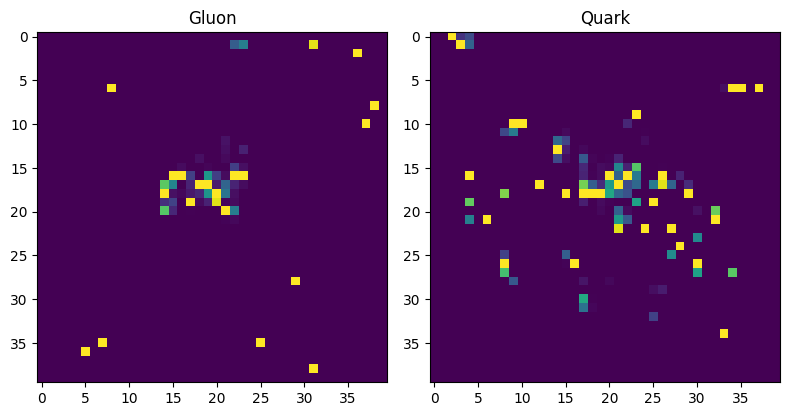

In [72]:
#Y_train = (Y_train+1)/2
#Y_train

n = 50

plt.figure(figsize=(8,4))
#print(Y_train[Y_train==0][0])
plt.subplot(1,2,1)
plt.title("Gluon")
plt.imshow(X_train[Y_train==0][n])

plt.subplot(1,2,2)
plt.title("Quark")
#print(Y_train[Y_train==1][0])
plt.imshow(X_train[Y_train==1][n])


plt.tight_layout()  
plt.show()

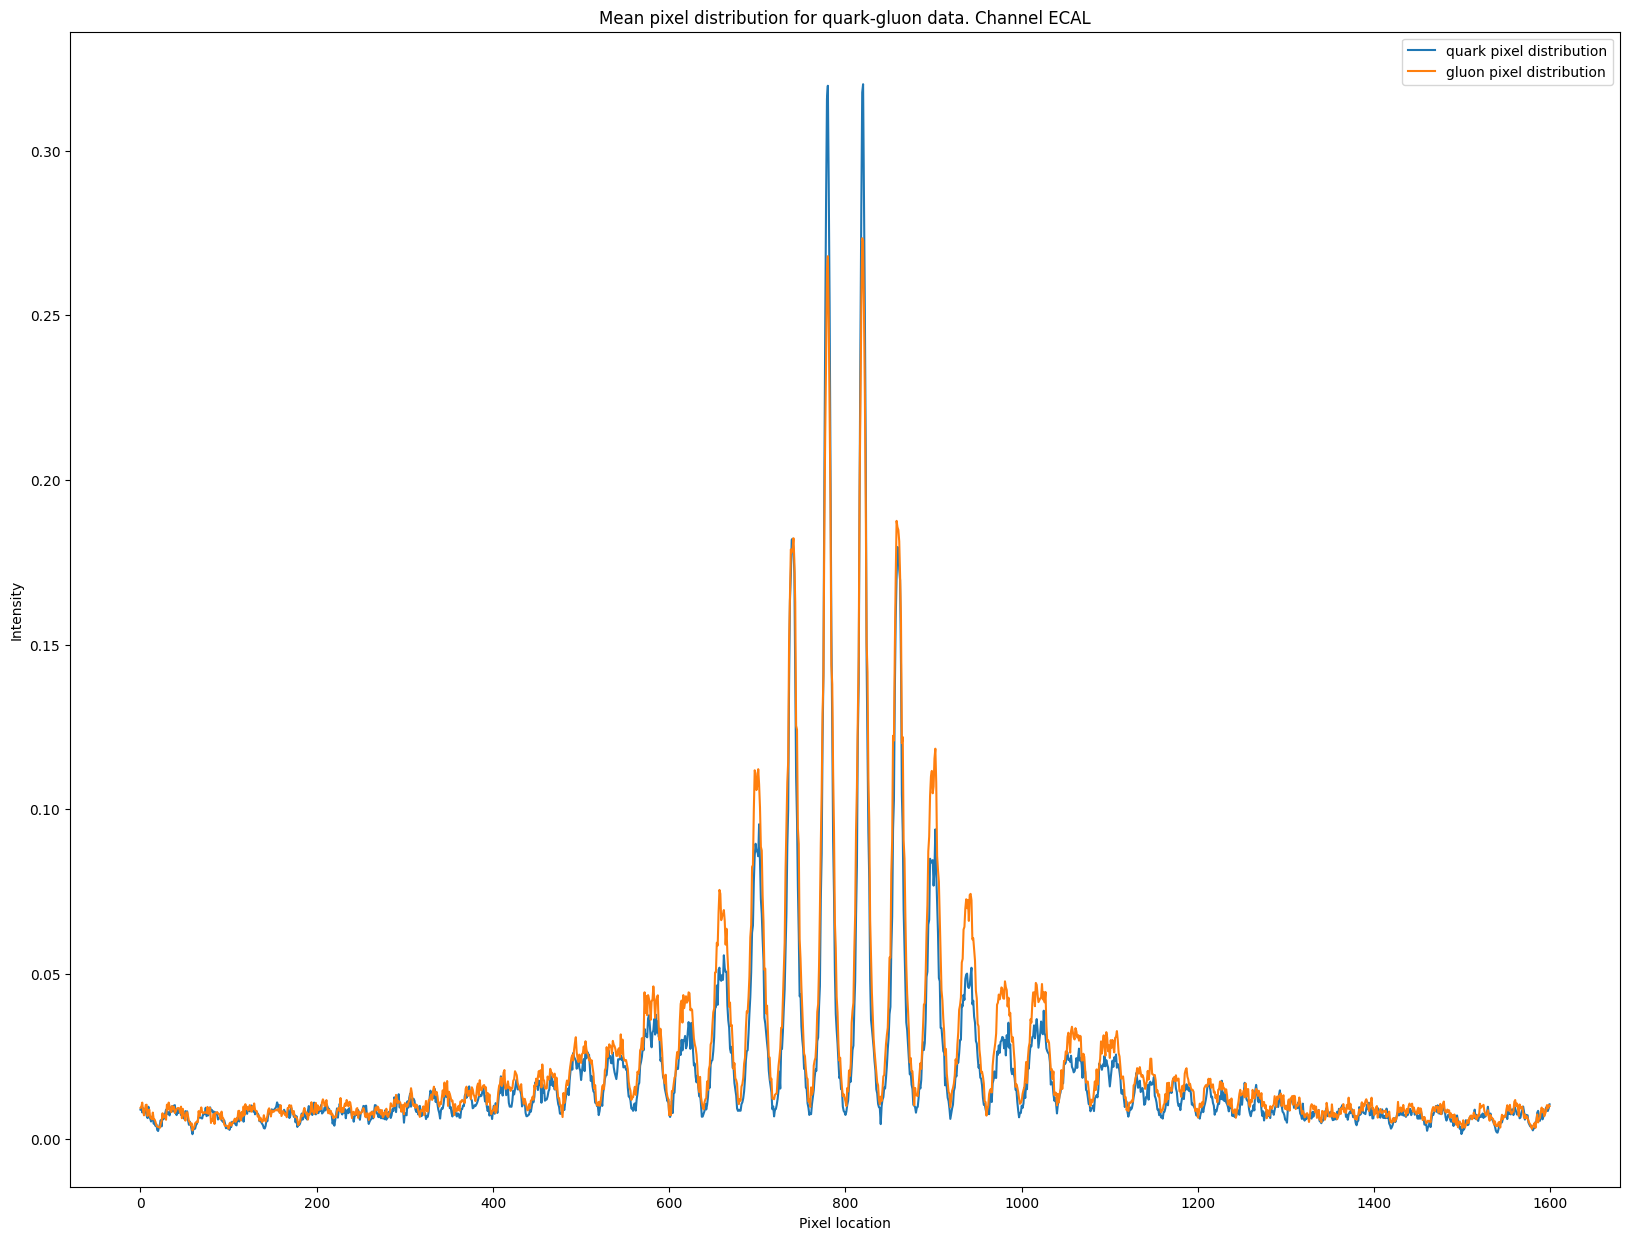

mean square difference between mean quark and gluon: -5.824646949768066


In [63]:
import pandas as pd
def plot_mean_pixel_distribution(x_data, y_data, channel=1, image_shape=(16, 16), figsize=(20, 15)):
    """
    Plots the mean pixel distribution for quark and gluon data.

    Parameters:
    - x_data: numpy array of images.
    - y_data: numpy array of labels.
    - channel: channel to use for the data (default is 1 for ECAL).
    - image_shape: shape of the images (default is (16, 16)).
    - figsize: size of the figure (default is (25, 18)).
    """
    plt.figure(figsize=figsize)

    # Split quark and gluon data
    quark = x_data[np.array(y_data) == 1]
    gluon = x_data[np.array(y_data) == 0]
    channels =["tracker", "ECAL", "HCAL"]

    # Flatten the data
    quark_flat = np.array([img.reshape(np.prod(image_shape)) for img in quark])
    gluon_flat = np.array([img.reshape(np.prod(image_shape)) for img in gluon])

    # Calculate the mean value per pixel in each kind of data
    average_quark_pixel_values = np.mean(quark_flat, axis=0)
    average_gluon_pixel_values = np.mean(gluon_flat, axis=0)

    # Create a dataframe with the mean values for gluon and quark data and a list with all the pixels
    df = {"pixel": np.arange(np.prod(image_shape)),
          "quark_value": average_quark_pixel_values,
          "gluon_value": average_gluon_pixel_values}
    df = pd.DataFrame(df)

    # Plot the distributions
    plt.plot(df["pixel"], df["quark_value"], label="quark pixel distribution")
    plt.plot(df["pixel"], df["gluon_value"], label="gluon pixel distribution")

    plt.xlabel('Pixel location')
    plt.ylabel('Intensity')
    plt.title(f'Mean pixel distribution for quark-gluon data. Channel {channels[channel]}')
    plt.legend()
    plt.show()

    print(f"mean square difference between mean quark and gluon: {(np.abs(average_quark_pixel_values) - np.abs(average_gluon_pixel_values)).sum()}")


plot_mean_pixel_distribution(X_train,Y_train,1, image_shape=(40,40))


In [56]:
np.unique(Y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([5552, 5698]))

In [67]:
history = model.fit(X_train,Y_train, epochs=50, batch_size=32, validation_split=0.45)


Epoch 1/50
194/194 [==============================] - 24s 122ms/step - loss: 0.5675 - accuracy: 0.7097 - val_loss: 0.6560 - val_accuracy: 0.6350
Epoch 2/50
194/194 [==============================] - 20s 104ms/step - loss: 0.5693 - accuracy: 0.7081 - val_loss: 0.6634 - val_accuracy: 0.6283
Epoch 3/50
194/194 [==============================] - 5s 24ms/step - loss: 0.5683 - accuracy: 0.7163 - val_loss: 0.6630 - val_accuracy: 0.6303
Epoch 4/50
194/194 [==============================] - 2s 11ms/step - loss: 0.5696 - accuracy: 0.7097 - val_loss: 0.6605 - val_accuracy: 0.6322
Epoch 5/50
194/194 [==============================] - 21s 106ms/step - loss: 0.5643 - accuracy: 0.7089 - val_loss: 0.6651 - val_accuracy: 0.6301
Epoch 6/50
194/194 [==============================] - 20s 101ms/step - loss: 0.5676 - accuracy: 0.7083 - val_loss: 0.6638 - val_accuracy: 0.6267
Epoch 7/50
194/194 [==============================] - 20s 101ms/step - loss: 0.5640 - accuracy: 0.7131 - val_loss: 0.6669 - val_accura

In [68]:
model.evaluate(X_test,Y_test)

118/118 [==============================] - 1s 7ms/step - loss: 0.7778 - accuracy: 0.5928


[0.7777546048164368, 0.5928000211715698]

118/118 [==============================] - 1s 4ms/step - loss: 0.7778 - accuracy: 0.5928
Test accuracy: 0.5928000211715698


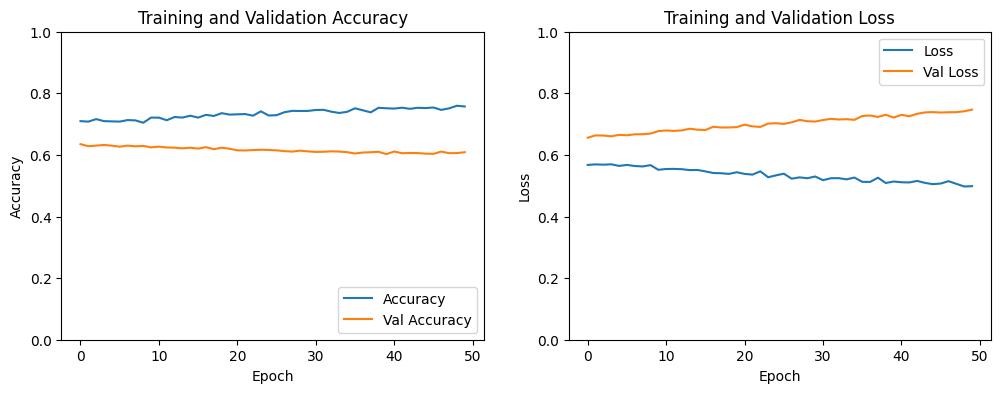

In [69]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(Y_test))
print(f'Test accuracy: {test_acc}')

# Graficar las métricas de entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
